In [1]:
%matplotlib inline

<div class="alert alert-danger">
<h3>Disclaimer</h3>
The package <code>nistats</code> will soon be merged into <code>nilearn</code> and all of its functionality will be available in the release of <code>nilearn</code> 0.7.0 in late 2020. Instead of using the retired version of <code>nistats</code>, we decided to already provide a brief spoiler of how things look in the new version (by installing <code>nilearn</code> from the current <code>main branch</code>. While drastic changes regarding functions and modules shouldn't be a thin, please watch out for smaller differences like <code>arguments</code>, <code>function/argument names/defaults</code>, etc. . 
</div>



Nilearn GLM: statistical analyses of MRI in Python
=========================================================

[Nilearn]()'s [GLM/stats]() module allows fast and easy MRI statistical analysis.

It leverages [Nibabel]() and other Python libraries from the Python scientific stack like [Scipy](), [Numpy]() and [Pandas]().

In this tutorial, we're going to explore `nilearn's GLM` functionality by analyzing 1) a single subject single run and 2) three subject group level example using a General Linear Model (GLM). We're gonna use the same example dataset (ds000114) as from the `nibabel` and `nilearn` tutorials. As this is a multi run multi task dataset, we've to decide on a run and a task we want to analyze. Let's go with `ses-test` and `task-fingerfootlips`, starting with a single subject `sub-01`. 

# Individual level analysis

Setting and inspecting the data
=========================

At first, we have to set and indicate the data we want to analyze. As stated above, we're going to use the anatomical image and the preprocessed functional image of `sub-01` from `ses-test`. The preprocessing was conducted through [fmriprep](https://fmriprep.readthedocs.io/en/stable/index.html).

In [2]:
fmri_img = '/data/ds000114/derivatives/fmriprep/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_space-MNI152nlin2009casym_desc-preproc_bold.nii.gz'
anat_img = '/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz'

We can display the mean functional image and the subject's anatomy:

In [3]:
from nilearn.image import mean_img
mean_img = mean_img(fmri_img)

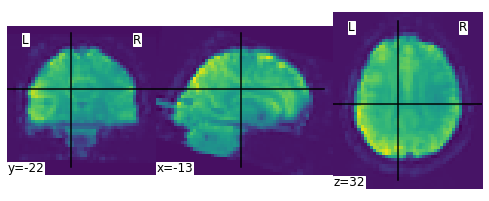

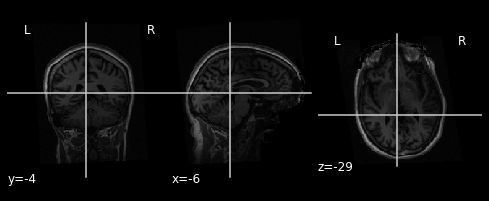

In [4]:
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show, plot_glass_brain
plot_img(mean_img)
plot_anat(anat_img)

Specifying the experimental paradigm
------------------------------------

We must now provide a description of the experiment, that is, define the
timing of the task and rest periods. This is typically
provided in an events.tsv file.



In [5]:
import pandas as pd
events = pd.read_table('/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_events.tsv')
print(events)

    onset  duration  weight trial_type
0      10      15.0       1     Finger
1      40      15.0       1       Foot
2      70      15.0       1       Lips
3     100      15.0       1     Finger
4     130      15.0       1       Foot
5     160      15.0       1       Lips
6     190      15.0       1     Finger
7     220      15.0       1       Foot
8     250      15.0       1       Lips
9     280      15.0       1     Finger
10    310      15.0       1       Foot
11    340      15.0       1       Lips
12    370      15.0       1     Finger
13    400      15.0       1       Foot
14    430      15.0       1       Lips


Performing the GLM analysis
---------------------------

It is now time to create and estimate a ``FirstLevelModel`` object, that will generate the *design matrix* using the  information provided by the ``events`` object.



In [6]:
from nilearn.glm.first_level import FirstLevelModel

There are a lot of important parameters one needs to define within a `FirstLevelModel` and the majority of them will have a prominent influence on your results. Thus, make sure to check them before running your model:


In [7]:
FirstLevelModel?

We need the TR of the functional images, luckily we can extract that information using `nibabel`:

In [8]:
!nib-ls /data/ds000114/derivatives/fmriprep/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_space-MNI152nlin2009casym_desc-preproc_bold.nii.gz

/data/ds000114/derivatives/fmriprep/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_space-MNI152nlin2009casym_desc-preproc_bold.nii.gz float32 [ 49,  58,  49, 184] 4.00x4.00x4.00x2.50



As we can see the `TR` is 2.5.

In [9]:
fmri_glm = FirstLevelModel(t_r=2.5,
                           noise_model='ar1',
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=1./160,
                           signal_scaling=False,
                           minimize_memory=False)

Usually, we also want to include confounds computed during preprocessing (e.g., motion, global signal, etc.) as regressors of no interest. In our example, these were computed by `fmriprep` and can be found in `derivatives/fmriprep/sub-01/func/`. We can use `pandas` to inspect that file:

In [10]:
import pandas as pd
confounds = pd.read_csv('/data/ds000114/derivatives/fmriprep/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold_desc-confounds_timeseries.tsv', delimiter='\t')
confounds

,WhiteMatter,GlobalSignal,stdDVARS,non-stdDVARS,vx-wisestdDVARS,FramewiseDisplacement,tCompCor00,tCompCor01,tCompCor02,tCompCor03,...,aCompCor02,aCompCor03,aCompCor04,aCompCor05,X,Y,Z,RotX,RotY,RotZ
0,59.958244,296.705627,NaN,NaN,NaN,NaN,-0.945194,0.178691,-0.008839,0.023860,...,0.001226,-0.070598,0.040292,-0.004502,-6.811590e-03,0.000000,0.000000,0.000000,-0.000000,0.000000
1,-0.992987,-6.791035,10.967166,359.572876,15.125442,0.522051,0.095183,-0.081205,0.043344,-0.067988,...,-0.006754,0.102960,-0.020727,0.005408,-1.198610e-09,-0.035396,0.386632,0.001864,-0.000000,0.000000
2,0.121577,-8.960917,0.965478,31.654449,1.251122,0.053361,0.039534,-0.048124,0.023519,-0.009606,...,-0.006754,0.096988,-0.022278,-0.102161,0.000000e+00,-0.019626,0.383440,0.001176,-0.000000,0.000000
3,-3.207463,-15.836485,0.568300,18.632469,0.933274,0.079333,0.064448,-0.049706,0.013449,-0.031648,...,-0.036826,0.078502,0.003200,-0.112108,0.000000e+00,-0.032375,0.430492,0.001567,-0.000000,0.000000
4,-3.531865,-16.072039,0.412484,13.523833,1.089049,0.030417,0.058324,-0.050976,0.013930,-0.027509,...,-0.024400,0.069612,0.006408,-0.060869,2.562640e-10,-0.032767,0.404579,0.001485,-0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,-1.131588,6.617327,0.796877,26.126665,0.812802,0.162573,0.001240,-0.007174,-0.044028,-0.010630,...,-0.076143,0.074762,0.004733,0.020203,-5.966000e-01,0.258395,1.762940,0.000232,0.003428,-0.013078
180,-2.441096,3.395323,0.606146,19.873285,0.689635,0.080021,0.003447,0.006033,-0.038060,0.003348,...,0.006482,0.081220,0.004589,-0.054566,-6.161150e-01,0.237964,1.772880,0.000388,0.003602,-0.013351
181,-4.028681,-0.000021,0.725305,23.780071,0.768956,0.195117,0.008511,0.018631,-0.045767,0.042005,...,0.019911,-0.027145,-0.028081,0.013844,-6.761900e-01,0.216604,1.814620,-0.000184,0.003883,-0.013937
182,-4.716608,0.375874,0.549176,18.005463,0.654098,0.085730,0.009503,0.000066,-0.031858,-0.026816,...,0.026724,0.012923,0.025031,0.012589,-6.877110e-01,0.198889,1.825820,-0.000529,0.004307,-0.013800


Comparable to other neuroimaging softwards, we have a timepoint x confound dataframe. However, `fmriprep` computes way more confounds than most of you are used to and that require a bit of reading to understand and therefore utilize properly. We therefore and for the sake of simplicity stick to the "classic" ones: `WhiteMatter`, `GlobalSignal`, `FramewiseDisplacement` and the `motion correction parameters` in translation and rotation: 

In [11]:
import numpy as np
confounds_glm = confounds[['WhiteMatter', 'GlobalSignal', 'FramewiseDisplacement', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']].replace(np.nan, 0)
confounds_glm

,WhiteMatter,GlobalSignal,FramewiseDisplacement,X,Y,Z,RotX,RotY,RotZ
0,59.958244,296.705627,0.000000,-6.811590e-03,0.000000,0.000000,0.000000,-0.000000,0.000000
1,-0.992987,-6.791035,0.522051,-1.198610e-09,-0.035396,0.386632,0.001864,-0.000000,0.000000
2,0.121577,-8.960917,0.053361,0.000000e+00,-0.019626,0.383440,0.001176,-0.000000,0.000000
3,-3.207463,-15.836485,0.079333,0.000000e+00,-0.032375,0.430492,0.001567,-0.000000,0.000000
4,-3.531865,-16.072039,0.030417,2.562640e-10,-0.032767,0.404579,0.001485,-0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
179,-1.131588,6.617327,0.162573,-5.966000e-01,0.258395,1.762940,0.000232,0.003428,-0.013078
180,-2.441096,3.395323,0.080021,-6.161150e-01,0.237964,1.772880,0.000388,0.003602,-0.013351
181,-4.028681,-0.000021,0.195117,-6.761900e-01,0.216604,1.814620,-0.000184,0.003883,-0.013937
182,-4.716608,0.375874,0.085730,-6.877110e-01,0.198889,1.825820,-0.000529,0.004307,-0.013800


Now that we have specified the model, we can run it on the fMRI image



In [12]:
fmri_glm = fmri_glm.fit(fmri_img, events, confounds_glm)

One can inspect the design matrix (rows represent time, and
columns contain the predictors).



In [13]:
design_matrix = fmri_glm.design_matrices_[0]

Formally, we have taken the first design matrix, because the model is
implictily meant to for multiple runs.



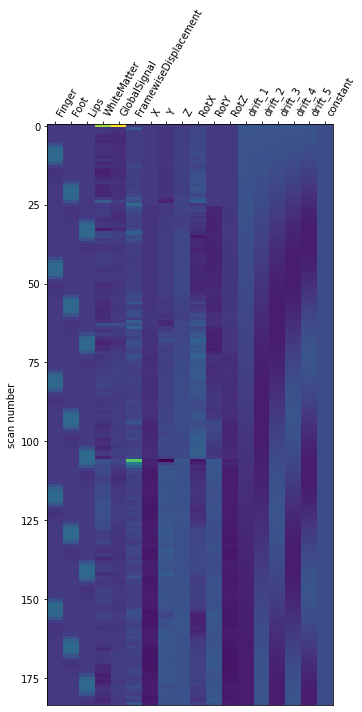

In [14]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrix)
import matplotlib.pyplot as plt
plt.show()

Save the design matrix image to disk, first creating a directory where you want to write the images:

In [15]:
import os
outdir = 'results'
if not os.path.exists(outdir):
    os.mkdir(outdir)

from os.path import join
plot_design_matrix(design_matrix, output_file=join(outdir, 'design_matrix.png'))

The first column contains the expected reponse profile of regions which are
sensitive to the "Finger" task. Let's plot this first column:



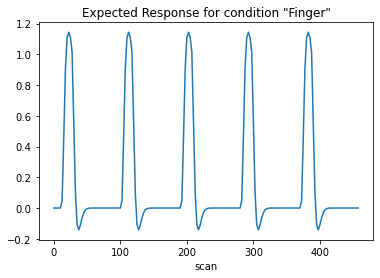

In [16]:
plt.plot(design_matrix['Finger'])
plt.xlabel('scan')
plt.title('Expected Response for condition "Finger"')
plt.show()

Detecting voxels with significant effects
-----------------------------------------

To access the estimated coefficients (Betas of the GLM model), we
created constrast with a single '1' in each of the columns: The role
of the contrast is to select some columns of the model --and
potentially weight them-- to study the associated statistics. So in
a nutshell, a contrast is a weigted combination of the estimated
effects.  Here we can define canonical contrasts that just consider
the two condition in isolation ---let's call them "conditions"---
then a contrast that makes the difference between these conditions.



In [17]:
from numpy import array
conditions = {
    'active - Finger': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'active - Foot':   array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'active - Lips':   array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
}

Let's look at it: plot the coefficients of the contrast, indexed by
the names of the columns of the design matrix.



<AxesSubplot:label='conditions'>

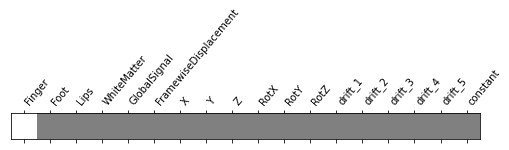

In [18]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(conditions['active - Finger'], design_matrix=design_matrix)

Below, we compute the estimated effect. It is in BOLD signal unit,
but has no statistical guarantees, because it does not take into
account the associated variance.



In [19]:
eff_map = fmri_glm.compute_contrast(conditions['active - Finger'],
                                    output_type='effect_size')

In order to get statistical significance, we form a t-statistic, and
directly convert is into z-scale. The z-scale means that the values
are scaled to match a standard Gaussian distribution (mean=0,
variance=1), across voxels, if there were now effects in the data.



In [20]:
z_map = fmri_glm.compute_contrast(conditions['active - Finger'],
                                  output_type='z_score')

Plot thresholded z scores map.

We display it on top of the average
functional image of the series (could be the anatomical image of the
subject).  We use arbitrarily a threshold of 3.0 in z-scale. We'll
see later how to use corrected thresholds.  we show to display 3
axial views: display_mode='z', cut_coords=3

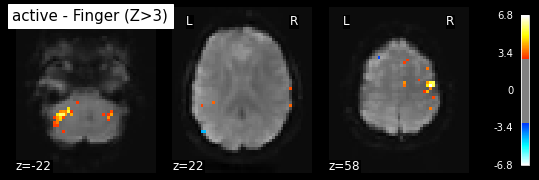

In [21]:
plot_stat_map(z_map, bg_img=mean_img, threshold=3.0,
              display_mode='z', cut_coords=3, black_bg=True,
              title='active - Finger (Z>3)')
plt.show()

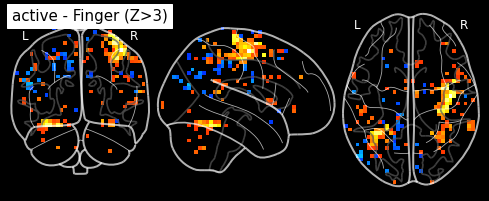

In [22]:
plot_glass_brain(z_map, threshold=3.0, black_bg=True, plot_abs=False,
                 title='active - Finger (Z>3)')
plt.show()

Statistical signifiance testing. One should worry about the
statistical validity of the procedure: here we used an arbitrary
threshold of 3.0 but the threshold should provide some guarantees on
the risk of false detections (aka type-1 errors in statistics). One
first suggestion is to control the false positive rate (fpr) at a
certain level, e.g. 0.001: this means that there is.1% chance of
declaring active an inactive voxel.

Uncorrected p<0.001 threshold: 3.291


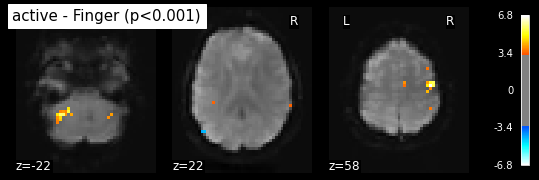

In [23]:
from nilearn.glm.thresholding import threshold_stats_img
_, threshold = threshold_stats_img(z_map, alpha=.001, height_control='fpr')
print('Uncorrected p<0.001 threshold: %.3f' % threshold)
plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='active - Finger (p<0.001)')
plt.show()

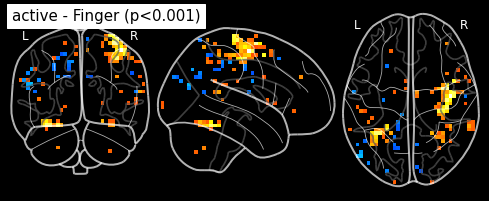

In [24]:
plot_glass_brain(z_map, threshold=threshold, black_bg=True, plot_abs=False,
                 title='active - Finger (p<0.001)')
plt.show()

The problem is that with this you expect 0.001 * n_voxels to show up
while they're not active --- tens to hundreds of voxels. A more
conservative solution is to control the family wise errro rate,
i.e. the probability of making ony one false detection, say at
5%. For that we use the so-called Bonferroni correction:



Bonferroni-corrected, p<0.05 threshold: 4.763


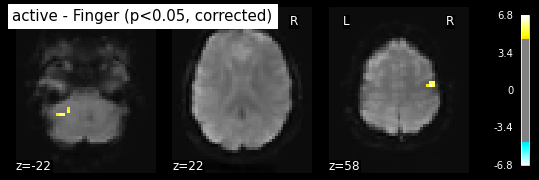

In [25]:
_, threshold = threshold_stats_img(z_map, alpha=.05, height_control='bonferroni')
print('Bonferroni-corrected, p<0.05 threshold: %.3f' % threshold)
plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='active - Finger (p<0.05, corrected)')
plt.show()

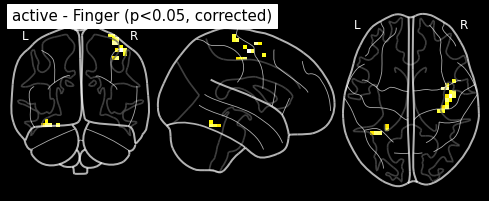

In [26]:
plot_glass_brain(z_map, threshold=threshold, black_bg=True, plot_abs=False,
                 title='active - Finger (p<0.05, corrected)')
plt.show()

This is quite conservative indeed !  A popular alternative is to
control the false discovery rate, i.e. the expected proportion of
false discoveries among detections. This is called the false
disovery rate.



False Discovery rate = 0.05 threshold: 3.779


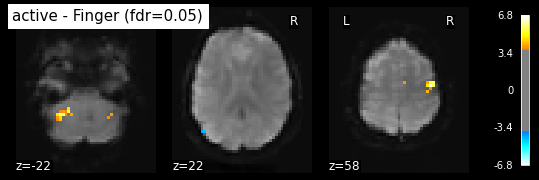

In [27]:
_, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr')
print('False Discovery rate = 0.05 threshold: %.3f' % threshold)
plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='active - Finger (fdr=0.05)')
plt.show()

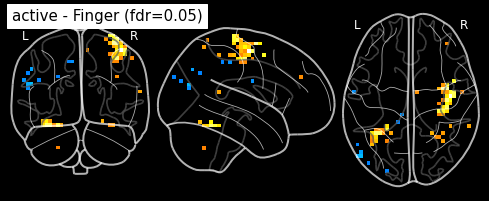

In [28]:
plot_glass_brain(z_map, threshold=threshold, black_bg=True, plot_abs=False,
                 title='active - Finger (fdr=0.05)')
plt.show()

Finally people like to discard isolated voxels (aka "small
clusters") from these images. It is possible to generate a
thresholded map with small clusters removed by providing a
cluster_threshold argument. here clusters smaller than 10 voxels
will be discarded.



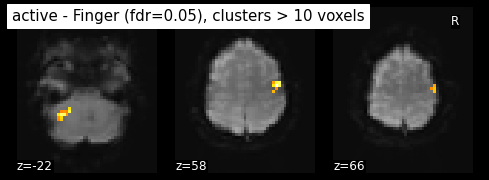

In [29]:
clean_map, threshold = threshold_stats_img(
    z_map, alpha=.05, height_control='fdr', cluster_threshold=10)
plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True, colorbar=False,
              title='active - Finger (fdr=0.05), clusters > 10 voxels')
plt.show()

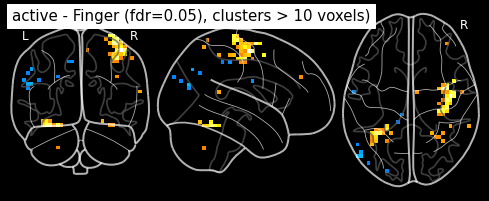

In [30]:
plot_glass_brain(z_map, threshold=threshold, black_bg=True, plot_abs=False,
                 title='active - Finger (fdr=0.05), clusters > 10 voxels)')
plt.show()

We can save the effect and zscore maps to the disk



In [31]:
z_map.to_filename(join(outdir, 'sub-01_ses-test_task-footfingerlips_space-MNI152nlin2009casym_desc-finger_zmap.nii.gz'))
eff_map.to_filename(join(outdir, 'sub-01_ses-test_task-footfingerlips_space-MNI152nlin2009casym_desc-finger_effmap.nii.gz'))

Report the found positions in a table



In [32]:
from nilearn.reporting import get_clusters_table
table = get_clusters_table(z_map, stat_threshold=threshold,
                           cluster_threshold=20)
print(table)

  Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0          1  44.0 -12.0  58.0   6.814199               1600
1         1a  40.0 -16.0  50.0   5.930616                   


This table can be saved for future use:



In [33]:
table.to_csv(join(outdir, 'table.csv'))

Or use [atlasreader](https://github.com/miykael/atlasreader) to get even more information and informative figures:

In [34]:
from atlasreader import create_output
from os.path import join
z_map.to_filename(join(outdir, 'active_finger_z_map.nii.gz'))
create_output(join(outdir, 'active_finger_z_map.nii.gz'),
              cluster_extent=5, voxel_thresh=threshold)

The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data



Let's have a look at the csv file containing relevant information about the peak of each cluster. This table contains the cluster association and location of each peak, its signal value at this location, the cluster extent (in mm, not in number of voxels), as well as the membership of each peak, given a particular atlas.

In [35]:
peak_info = pd.read_csv('results/active_finger_z_map_peaks.csv')
peak_info

,cluster_id,peak_x,peak_y,peak_z,peak_value,volume_mm,aal,desikan_killiany,harvard_oxford
0,1,44,-12,58,6.81420,1600,Precentral_R,ctx-rh-precentral,63.0% Right_Precentral_Gyrus; 13.0% Right_Post...
1,2,-36,-52,-22,5.81081,960,Fusiform_L,Unknown,64.0% Left_Temporal_Occipital_Fusiform_Cortex;...
2,3,40,-4,66,6.20802,384,no_label,Unknown,16.0% Right_Precentral_Gyrus


And the clusters:

In [36]:
cluster_info = pd.read_csv('results/active_finger_z_map_clusters.csv')
cluster_info

,cluster_id,peak_x,peak_y,peak_z,cluster_mean,volume_mm,aal,desikan_killiany,harvard_oxford
0,1,44,-12,58,4.63419,1600,92.00% Precentral_R; 8.00% Postcentral_R,44.00% Unknown; 28.00% Right-Cerebral-White-Ma...,88.00% Right_Precentral_Gyrus; 12.00% Right_Po...
1,2,-36,-52,-22,4.55116,960,66.67% Fusiform_L; 20.00% Cerebelum_6_L; 13.33...,53.33% Unknown; 33.33% Left-Cerebellum-Cortex;...,86.67% Left_Temporal_Occipital_Fusiform_Cortex...
2,3,40,-4,66,4.94016,384,66.67% Frontal_Sup_2_R; 33.33% no_label,83.33% Unknown; 16.67% ctx-rh-precentral,66.67% Right_Precentral_Gyrus; 33.33% Right_Mi...


For each cluster, we also get a corresponding visualization, saved as `.png`:

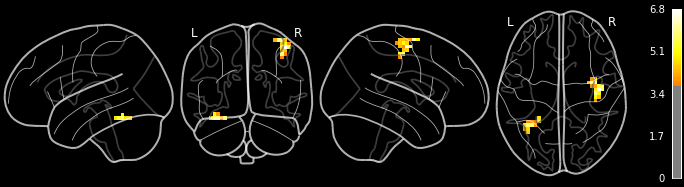

In [37]:
from IPython.display import Image
Image("results/active_finger_z_map.png")

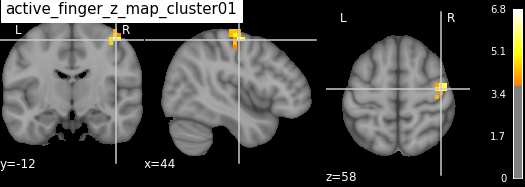

In [38]:
Image("results/active_finger_z_map_cluster01.png")

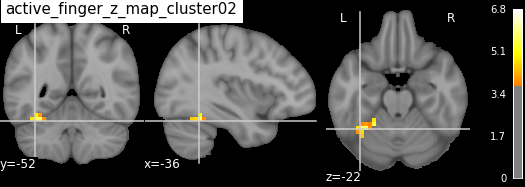

In [39]:
Image("results/active_finger_z_map_cluster02.png")

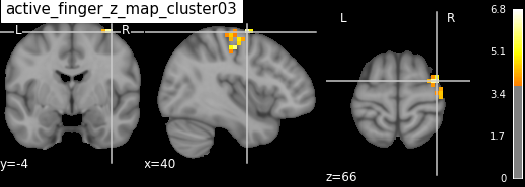

In [40]:
Image("results/active_finger_z_map_cluster03.png")

But wait, there's more! There's even a functionality to create entire `GLM reports` including information regarding the `model` and its `parameters`, `design matrix`, `contrasts`, etc. . All we need is the `make_glm_report` function from `nilearn.reporting` and apply it to our `fitted GLM`, specifying a `contrast of interest`. 

In [41]:
from nilearn.reporting import make_glm_report

report = make_glm_report(fmri_glm,
                         contrasts='Finger',
                         bg_img=mean_img
                         )

Once generated, we have several options to view the `GLM report`: directly in the `notebook`, in the `browser` or save it as an `html` file:

In [42]:
report
#report.open_in_browser()
#report.save_as_html("GLM_report.html")

### Performing an F-test

"active vs rest" is a typical t test: condition versus
baseline. Another popular type of test is an F test in which one
seeks whether a certain combination of conditions (possibly two-,
three- or higher-dimensional) explains a significant proportion of
the signal.  Here one might for instance test which voxels are well
explained by combination of the active and rest condition.



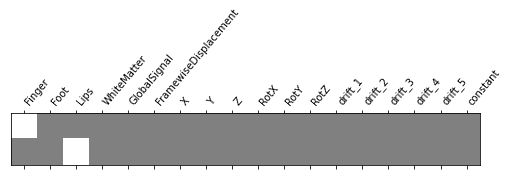

In [43]:
import numpy as np
effects_of_interest = np.vstack((conditions['active - Finger'], conditions['active - Lips']))
plot_contrast_matrix(effects_of_interest, design_matrix)
plt.show()

Specify the contrast and compute the correspoding map. Actually, the
contrast specification is done exactly the same way as for t
contrasts.



In [44]:
z_map = fmri_glm.compute_contrast(effects_of_interest,
                                  output_type='z_score')

Note that the statistic has been converted to a z-variable, which
makes it easier to represent it.



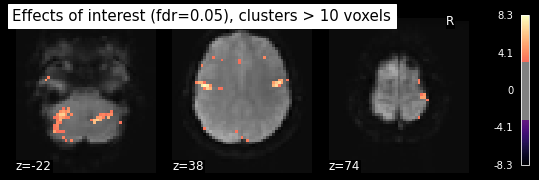

In [45]:
clean_map, threshold = threshold_stats_img(
    z_map, alpha=.05, height_control='fdr', cluster_threshold=0)
plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Effects of interest (fdr=0.05), clusters > 10 voxels', cmap='magma')
plt.show()

### Evaluating models
While not commonly done, it's a very good and important idea to actually evaluate your model in terms of its fit. We can do that comprehensively, yet easily through `nilearn` functionality. In more detail, we're going to inspect the residuals and evaluate the predicted time series. Let's  do this for the peak voxels. At first, we have to extract them using `get_clusters_table`:

In [46]:
table = get_clusters_table(z_map, stat_threshold=1,
                           cluster_threshold=20).set_index('Cluster ID', drop=True)
table.head()

,X,Y,Z,Peak Stat,Cluster Size (mm3)
Cluster ID,,,,,
1,-52.0,-12.0,38.0,8.256954,320064
1a,56.0,-8.0,34.0,7.590617,
1b,40.0,-4.0,66.0,7.410259,
1c,-32.0,-52.0,-22.0,6.705043,
2,-12.0,-92.0,34.0,5.798149,8064


From this `dataframe`, we get the `largest clusters` and prepare a `masker` to extract their `time series`:

In [47]:
from nilearn import input_data

# get the largest clusters' max x, y, and z coordinates
coords = table.loc[range(1, 7), ['X', 'Y', 'Z']].values

# extract time series from each coordinate
masker = input_data.NiftiSpheresMasker(coords)

#### Get and check model residuals
We can simply obtain the `residuals` of the peak voxels from our `fitted model` via applying the prepared `masker` (and thus `peak voxel`) to the `residuals` our:

In [48]:
resid = masker.fit_transform(fmri_glm.residuals[0])

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/glm/regression.py:341: FutureWarning: 'resid' from RegressionResults has been deprecated and will be removed. Please use 'residuals' instead.
  FutureWarning,


And now, we can plot them and evaluate our `peak voxels` based on their `distribution` of `residuals`:

Mean residuals: 569.9211479152834
Mean residuals: 253.89929545754694
Mean residuals: 293.1701082605038
Mean residuals: 418.41548583493443
Mean residuals: 190.16504316358782
Mean residuals: 446.75769196110303


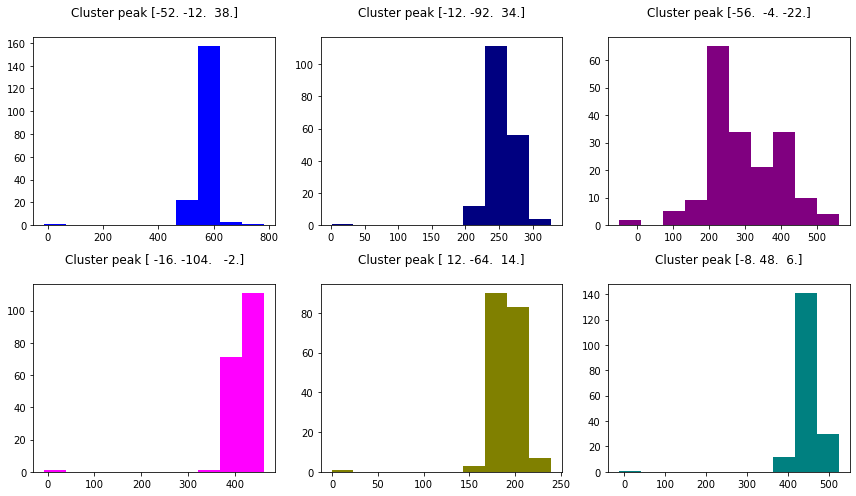

In [49]:
# colors for each of the clusters
colors = ['blue', 'navy', 'purple', 'magenta', 'olive', 'teal']


fig2, axs2 = plt.subplots(2, 3)
axs2 = axs2.flatten()
for i in range(0, 6):
    axs2[i].set_title('Cluster peak {}\n'.format(coords[i]))
    axs2[i].hist(resid[:, i], color=colors[i])
    print('Mean residuals: {}'.format(resid[:, i].mean()))

fig2.set_size_inches(12, 7)
fig2.tight_layout()

#### Get and check predicted time series

In order to evaluate the `predicted time series` we need to extract them, as well as the `actual time series`. To do so, we can use the `masker` again:

In [50]:
real_timeseries = masker.fit_transform(fmri_img)
predicted_timeseries = masker.fit_transform(fmri_glm.predicted[0])

Having obtained both `time series`, we can plot them against each other. To make it more informative, we will also visualize the respective `peak voxels` on the `mean functional image`:

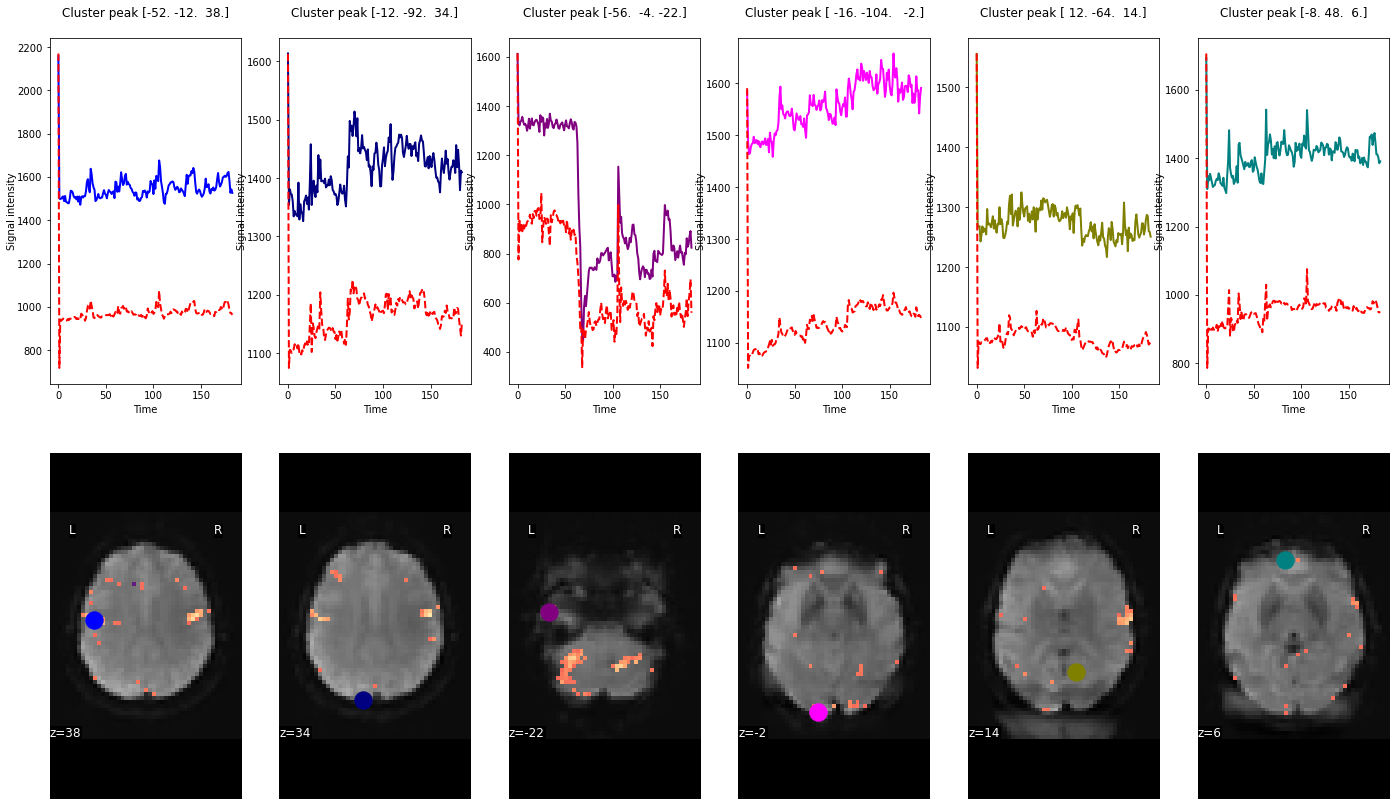

In [51]:
from nilearn import plotting

# plot the time series and corresponding locations
fig1, axs1 = plt.subplots(2, 6)
for i in range(0, 6):
    # plotting time series
    axs1[0, i].set_title('Cluster peak {}\n'.format(coords[i]))
    axs1[0, i].plot(real_timeseries[:, i], c=colors[i], lw=2)
    axs1[0, i].plot(predicted_timeseries[:, i], c='r', ls='--', lw=2)
    axs1[0, i].set_xlabel('Time')
    axs1[0, i].set_ylabel('Signal intensity', labelpad=0)
    # plotting image below the time series
    roi_img = plotting.plot_stat_map(
        z_map, cut_coords=[coords[i][2]], threshold=3.1, figure=fig1,
        axes=axs1[1, i], display_mode='z', colorbar=False, bg_img=mean_img, cmap='magma')
    roi_img.add_markers([coords[i]], colors[i], 300)
fig1.set_size_inches(24, 14)

#### Plot the R-squared
Another option to evaluate our model is to plot the `R-squared`, that is the amount of variance explained through our `GLM` in total. While this plot will be informative, its interpretation will be limited as we can't tell if a voxel exhibits a large `R-squared` because of a response to a `condition` in our experiment or to `noise`. For these things, one should employ `F-Tests` as shown above. However, as expected we see that the `R-squared` decreases the further away `voxels` are from the `receive coils` (e.g. deeper in the brain).

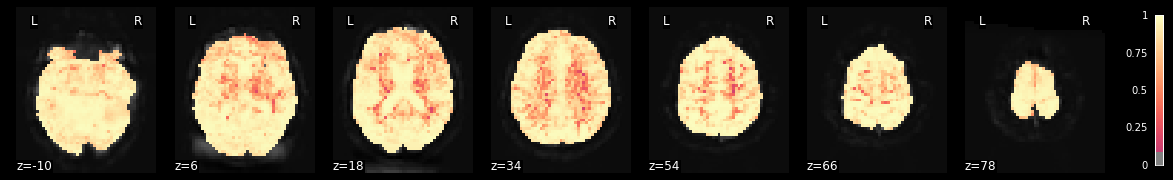

In [52]:
plotting.plot_stat_map(fmri_glm.r_square[0], bg_img=mean_img, threshold=.1,
                       display_mode='z', cut_coords=7, cmap='magma')

## Group level statistics
Now that we've explored the individual level analysis quite a bit, one might ask: but what about `group level` statistics? No problem at all, `nilearn`'s `GLM` functionality of course supports this as well. As in other software packages, we need to repeat the `individual level analysis` for each subject to obtain the same contrast images, that we can submit to a `group level analysis`. 

### Run individual level analysis for multiple participants
By now, we know how to do this easily. Let's use a simple `for loop` to repeat the analysis from above for `sub-02` and `sub-03`.

In [53]:
for subject in ['02', '03']:

    # set the fMRI image
    fmri_img = '/data/ds000114/derivatives/fmriprep/sub-%s/ses-test/func/sub-%s_ses-test_task-fingerfootlips_space-MNI152nlin2009casym_desc-preproc_bold.nii.gz' %(subject, subject)
    
    # read in the events 
    events = pd.read_table('/data/ds000114/sub-%s/ses-test/func/sub-%s_ses-test_task-fingerfootlips_events.tsv' %(subject, subject))
    
    # read in the confounds
    confounds = pd.read_table('/data/ds000114/derivatives/fmriprep/sub-%s/ses-test/func/sub-%s_ses-test_task-fingerfootlips_bold_desc-confounds_timeseries.tsv' %(subject, subject))
    
    # restrict the to be included confounds to a subset
    confounds_glm = confounds[['WhiteMatter', 'GlobalSignal', 'FramewiseDisplacement', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']].replace(np.nan, 0)
    
    # run the GLM
    fmri_glm = fmri_glm.fit(fmri_img, events, confounds_glm)
    
    # compute the contrast as a z-map
    z_map = fmri_glm.compute_contrast(conditions['active - Finger'],
                                  output_type='z_score')
    
    # save the z-map
    z_map.to_filename(join(outdir, 'sub-%s_ses-test_task-footfingerlips_space-MNI152nlin2009casym_desc-finger_zmap.nii.gz' %subject))

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/_utils/glm.py:276: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


### Define a group level model
As we now have the same contrast from multiple `subjects` we can define our `group level model`. At first, we need to gather the `individual contrast maps`: 

In [54]:
from glob import glob
list_z_maps = glob(join(outdir, 'sub-*_ses-test_task-footfingerlips_space-MNI152nlin2009casym_desc-finger_zmap.nii.gz'))

list_z_maps

['results/sub-02_ses-test_task-footfingerlips_space-MNI152nlin2009casym_desc-finger_zmap.nii.gz',
 'results/sub-03_ses-test_task-footfingerlips_space-MNI152nlin2009casym_desc-finger_zmap.nii.gz',
 'results/sub-01_ses-test_task-footfingerlips_space-MNI152nlin2009casym_desc-finger_zmap.nii.gz']

Great! The next step includes the definition of a `design matrix`. As we want to run a simple `one-sample t-test`, we just need to indicate as many `1` as we have `z-maps`:

In [55]:
design_matrix = pd.DataFrame([1] * len(list_z_maps),
                             columns=['intercept'])

Believe it or not, that's all it takes. Within the next step we can already set and run our model. It's basically identical to the `First_level_model`: we need to define the `images` and `design matrix`: 

In [56]:
from nilearn.glm.second_level import SecondLevelModel
second_level_model = SecondLevelModel()
second_level_model = second_level_model.fit(list_z_maps,
                                            design_matrix=design_matrix)

The same holds true for `contrast computation`:

In [57]:
z_map_group = second_level_model.compute_contrast(output_type='z_score')

What do we get? After defining a liberal threshold of `p<0.001 (uncorrected)`, we can plot our computed `group level contrast image`:

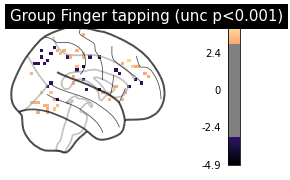

In [58]:
from scipy.stats import norm
p001_unc = norm.isf(0.001)

plotting.plot_glass_brain(z_map_group, colorbar=True, threshold=p001_unc,
                          title='Group Finger tapping (unc p<0.001)',
                          plot_abs=False, display_mode='x', cmap='magma')
plotting.show()

Well, not much going there...But please remember we also just included three participants. Besides this rather simple model, `nilearn`'s `GLM` functionality of course also allows you to run `paired t-test`, `two-sample t-test`, `F-test`, etc. . As shown above, you also can define different `thresholds` and `multiple comparison corrections`. There's yet another cool thing we didn't talk about. It's possible to run analyses in a rather automated way if your dataset is in `BIDS`.  

## Performing statistical analyses on BIDS datasets
Even though model specification and running was comparably easy and straightforward, it can be even better. `Nilearn`'s `GLM` functionality actually enables you to define models for multiple participants through one function by leveraging the `BIDS` standard. More precisely, the function `first_level_from_bids` takes the same input arguments as `First_Level_model` (e.g. `t_r`, `hrf_model`, `high_pass`, etc.), but through defining the `BIDS raw` and `derivatives folder`, as well as a `task` and `space` label automatically extracts all information necessary to run `individual level models` and creates the `model` itself for all participants. 

In [59]:
from nilearn.glm.first_level import first_level_from_bids

data_dir = '/data/ds000114/'
task_label = 'fingerfootlips'
space_label = 'MNI152nlin2009casym'
derivatives_folder = 'derivatives/fmriprep'

models, models_run_imgs, models_events, models_confounds = \
    first_level_from_bids(data_dir, task_label, space_label,
                          smoothing_fwhm=5.0,
                          derivatives_folder=derivatives_folder, 
                          t_r=2.5, 
                          noise_model='ar1',
                          hrf_model='spm',
                          drift_model='cosine',
                          high_pass=1./160,
                          signal_scaling=False,
                          minimize_memory=False)

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:811: UserWarning: RepetitionTime given in model_init as 2
  warn('RepetitionTime given in model_init as %d' % t_r)
/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:813: UserWarning: slice_time_ref is 0 percent of the repetition time
  'time' % slice_time_ref)


Done, let's check if things work as expected. As an example, we will have a look at the information for `sub-01`. We're going to start with the `images`.  

In [60]:
import os
print([os.path.basename(run) for run in models_run_imgs[0]])

['sub-01_ses-test_task-fingerfootlips_space-MNI152nlin2009casym_desc-preproc_bold.nii.gz']


Looks good. How about confounds?

In [61]:
print(models_confounds[0][0])

     WhiteMatter  GlobalSignal   stdDVARS  non-stdDVARS  vx-wisestdDVARS  \
0      59.958244    296.705627        NaN           NaN              NaN   
1      -0.992987     -6.791035  10.967166    359.572876        15.125442   
2       0.121577     -8.960917   0.965478     31.654449         1.251122   
3      -3.207463    -15.836485   0.568300     18.632469         0.933274   
4      -3.531865    -16.072039   0.412484     13.523833         1.089049   
..           ...           ...        ...           ...              ...   
179    -1.131588      6.617327   0.796877     26.126665         0.812802   
180    -2.441096      3.395323   0.606146     19.873285         0.689635   
181    -4.028681     -0.000021   0.725305     23.780071         0.768956   
182    -4.716608      0.375874   0.549176     18.005463         0.654098   
183    -2.884027      2.981873   0.582871     19.110176         0.675460   

     FramewiseDisplacement  tCompCor00  tCompCor01  tCompCor02  tCompCor03  \
0        

Ah, the `NaN` again. Let's fix those as we did last time, but for all participants.

In [62]:
models_confounds_no_nan = []

for confounds in models_confounds:
    models_confounds_no_nan.append(confounds[0].fillna(0)[['WhiteMatter', 'GlobalSignal', 'FramewiseDisplacement', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']])

Last but not least: how do the `events` look?

In [63]:
print(models_events[0][0]['trial_type'].value_counts())

Lips      5
Foot      5
Finger    5
Name: trial_type, dtype: int64


Fantastic, now we're ready to run our models. With a little `zip` magic this is done without a problem. We also going to compute `z-maps` as before and plot them side by side.

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/_utils/glm.py:276: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')
/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/plotting/displays.py:1110: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  .3 * (x1 - x0), y1 - y0], aspect='equal')


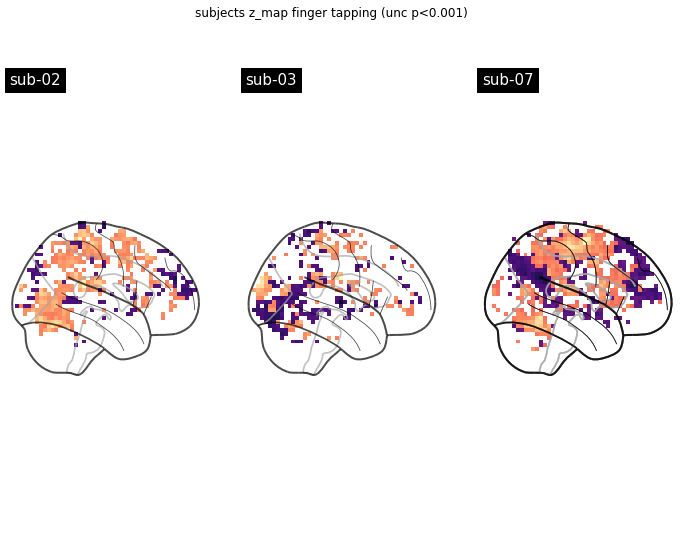

In [64]:
from nilearn import plotting
import matplotlib.pyplot as plt

models_fitted = [] 

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 8.5))
model_and_args = zip(models, models_run_imgs, models_events, models_confounds_no_nan)
for midx, (model, imgs, events, confounds) in enumerate(model_and_args):
    # fit the GLM
    model.fit(imgs, events, confounds)
        
    models_fitted.append(model)
    
    # compute the contrast of interest
    zmap = model.compute_contrast('Finger')
    plotting.plot_glass_brain(zmap, colorbar=False, threshold=p001_unc,
                              title=('sub-' + model.subject_label),
                              axes=axes[int(midx)-1],
                              plot_abs=False, display_mode='x', cmap='magma')
fig.suptitle('subjects z_map finger tapping (unc p<0.001)')
plotting.show()

That looks about right. However, let's also check the `design matrix`

<AxesSubplot:label='conditions', ylabel='scan number'>

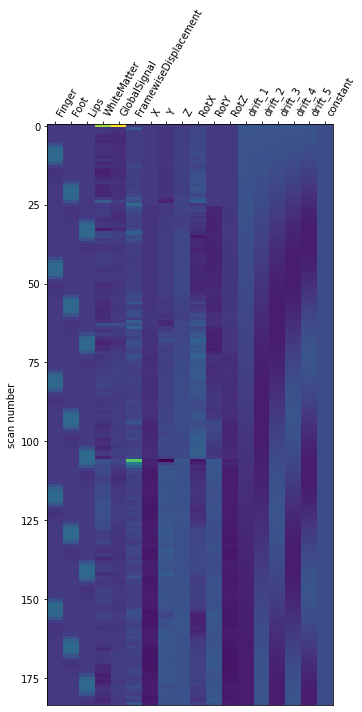

In [65]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(models_fitted[0].design_matrices_[0])

and `contrast matrix`.

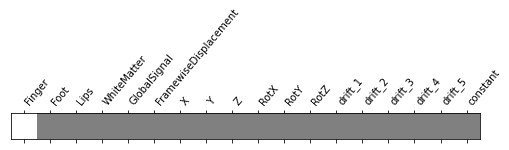

In [66]:
plot_contrast_matrix('Finger', models_fitted[0].design_matrices_[0])
plt.show()

Nothing to complain here and thus we can move on to the `group level model`. Instead of assembling `contrast images` from each participant, we also have the option to simply provide the `fitted individual level models` as input.

In [67]:
from nilearn.glm.second_level import SecondLevelModel
second_level_input = models_fitted

That's all it takes and we can run our `group level model` again.

In [68]:
second_level_model = SecondLevelModel()
second_level_model = second_level_model.fit(second_level_input)

And after computing the `contrast`

In [69]:
zmap = second_level_model.compute_contrast(
    first_level_contrast='Finger')

we can plot the results again.

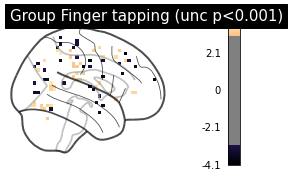

In [70]:
plotting.plot_glass_brain(zmap, colorbar=True, threshold=p001_unc,
                          title='Group Finger tapping (unc p<0.001)',
                          plot_abs=False, display_mode='x', cmap='magma')
plotting.show()

That's all for now. Please note, that we only showed a small part of what's possible. Make sure to check the documentation and the examples it includes. We hope we could show you how powerful `nilearn` will be through including `GLM` functionality  starting with the new release. While there's already a lot you can do, there will be even more in the future. 